In [16]:
import os
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import shapefile
import pandas as pd
import seaborn as sns
from scipy import stats 
import scipy
from scipy.special import factorial
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
import math
from cleanData import getCleanTripData, getCleanFareData, getTripData
from identifySuburbs import TaxiZone, Point, process_zones, haversine_distance, manhattan_distance


In [17]:
fare = getTripData('./data/loc_hash_3_trip_4_2013.csv')
len(fare.index)

441036

In [18]:
# Cleaning data
fare = getCleanFareData(fare)

In [19]:
#Feature engineering
fare['pickup_datetime'] = pd.to_datetime(fare.pickup_datetime) 
fare['pickup_day'] = fare['pickup_datetime'].dt.day
fare['pickup_hour'] = fare['pickup_datetime'].dt.hour
# I removed minite as it does not add much of importance.
#fare['pickup_minute'] = fare['pickup_datetime'].dt.minute
fare['pickup_weekday'] = fare['pickup_datetime'].dt.weekday
fare['pickup_weekhour'] = fare['pickup_datetime'].dt.weekday*24 + fare['pickup_hour']
fare['tip_percent'] = 100*fare['tip_amount'] / fare['total_amount']
fare.head(10)

,Unnamed: 0,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,...,tolls_amount,total_amount,id.1,pick_locid,drop_locid,pickup_day,pickup_hour,pickup_weekday,pickup_weekhour,tip_percent
0,4,205A696DF62AD03C88DA8C5EC5248639,579C41EA5EC846F8B641A42F9EE3E855,CMT,1,N,2013-04-04 20:12:57,2013-04-04 20:29:55,1,1017,...,0.0,19.20,205A696DF62AD03C88DA8C5EC5248639579C41EA5EC846...,246,141,4,20,3,92,16.666667
1,38,9827CDDA5D85B9C70A29ACE3824B644C,2BF23762F9D01A0723FE1B35996597C3,CMT,1,N,2013-04-04 14:39:58,2013-04-04 14:49:11,1,552,...,0.0,11.40,9827CDDA5D85B9C70A29ACE3824B644C2BF23762F9D01A...,239,48,4,14,3,86,16.666667
2,144,5BAA424F00F10358D10A8DCBBEDFDC27,91953611F278BD5D2B44C0FF82F45E1C,CMT,1,N,2013-04-04 07:37:50,2013-04-04 08:03:18,1,1528,...,0.0,31.00,5BAA424F00F10358D10A8DCBBEDFDC2791953611F278BD...,237,231,4,7,3,79,6.451613
3,156,49B8CFC71F0ED39C7B3F68F603DB9D05,5735FE2E3DC1CE2FC5DDA20579E1FD18,VTS,1,NaN,2013-04-12 23:29:00,2013-04-12 23:43:00,1,840,...,0.0,19.10,49B8CFC71F0ED39C7B3F68F603DB9D055735FE2E3DC1CE...,161,7,12,23,4,119,16.230366
4,178,AFE81C8DACF7151CBB3B2F4838883A8E,AF876139D0E7D99BE4F90FD49921559F,VTS,1,NaN,2013-04-12 23:39:00,2013-04-12 23:46:00,1,420,...,0.0,9.88,AFE81C8DACF7151CBB3B2F4838883A8EAF876139D0E7D9...,68,249,12,23,4,119,19.028340
5,273,B875FFF2BCDF2A6F478E6C8946F0B73F,9F2D5210E78A4AA91A5A854BD445638A,VTS,1,NaN,2013-04-12 21:38:00,2013-04-12 21:44:00,1,360,...,0.0,9.50,B875FFF2BCDF2A6F478E6C8946F0B73F9F2D5210E78A4A...,238,142,12,21,4,117,15.789474
6,277,84195E9B838F251839421FB79584959C,0D6843F0EE9575C7C9E771CF33E88D8F,VTS,1,NaN,2013-04-12 21:33:00,2013-04-12 21:44:00,1,660,...,0.0,11.00,84195E9B838F251839421FB79584959C0D6843F0EE9575...,262,238,12,21,4,117,0.000000
7,351,E90DABEB80622DD659FFC2153F4B3B6E,DF659312F3FF102358ED307B34E0C210,VTS,1,NaN,2013-04-12 20:16:00,2013-04-12 20:27:00,5,660,...,0.0,10.70,E90DABEB80622DD659FFC2153F4B3B6EDF659312F3FF10...,163,141,12,20,4,116,15.887850
8,432,47BF1F252F0CE798582074C829523047,244A7FCC015CF659EC7E3BFC3688C47A,VTS,1,NaN,2013-04-11 21:19:00,2013-04-11 21:26:00,4,420,...,0.0,10.70,47BF1F252F0CE798582074C829523047244A7FCC015CF6...,90,170,11,21,3,93,15.887850
9,440,FDAC52AC509274B36E441D632CCA4AF4,336319772BF19C7847815AFA031BF14C,VTS,1,NaN,2013-04-12 23:34:00,2013-04-12 23:42:00,6,480,...,0.0,11.00,FDAC52AC509274B36E441D632CCA4AF4336319772BF19C...,229,107,12,23,4,119,9.090909


In [37]:
#,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,
#passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,
#dropoff_latitude,id,medallion.1,hack_license.1,vendor_id.1,pickup_datetime.1,payment_type,
#fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,id.1,pick_locid,drop_locid
print('Started.')
# We only given time, pickup and dropoff location
zones = process_zones('./data/taxi_zones/taxi_zones.json')
alldata = fare[['id', 'pick_locid', 'drop_locid', #'fare_amount',
                'pickup_datetime', 'pickup_day','pickup_hour',
                'pickup_weekday','pickup_longitude', 
                'passenger_count','payment_type', 'tip_amount', 'tip_percent',
                'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']]

JFK_locid = 132
LaGuardia_locid = 138
Newark_locid = 1
airports = [JFK_locid, LaGuardia_locid, Newark_locid]

manhatten = []
for z in zones:
    if z.boro == "Manhattan":
        manhatten.append(z.locID)
manhetten_mapper_to = {}
manhetten_mapper_from = {}
airport_mapper = {}
for index, row in alldata.iterrows():
    ids = row['id']
    ploc = row['pick_locid']
    dloc = row['drop_locid']
    if ploc in manhatten:
        manhetten_mapper_from.update({ids: 1})
    else:
        manhetten_mapper_from.update({ids: 0})
    if dloc in manhatten:
        manhetten_mapper_to.update({ids: 1})
    else:
        manhetten_mapper_to.update({ids: 0})
        
    if ploc in airports or dloc in airports:
        airport_mapper.update({ids: 1})
    else:
        airport_mapper.update({ids: 0})

print("Done")

Started.
Done


In [38]:
s = time.time()
col1 = 'manhattan_to'
alldata = alldata.assign(**{col1:np.full(len(alldata.index), int(-2))})

col2 = 'manhattan_from'
alldata = alldata.assign(**{col1:np.full(len(alldata.index), int(-2))})

col3 = 'InAirports'
alldata = alldata.assign(**{col2:np.full(len(alldata.index), int(-2))})

alldata[col1] = alldata['id'].map(manhetten_mapper_to)
alldata[col2] = alldata['id'].map(manhetten_mapper_from)
alldata[col3] = alldata['id'].map(airport_mapper)
e = time.time()
print("Time: {} ".format(e-s))

Time: 1.4304568767547607 


In [39]:
alldata.loc[:,'hvsine_pick_drop'] = haversine_distance(alldata['pickup_latitude'].values, alldata['pickup_longitude'].values, alldata['dropoff_latitude'].values, alldata['dropoff_longitude'].values)
alldata.loc[:,'manh_pick_drop'] = manhattan_distance(alldata['pickup_latitude'].values, alldata['pickup_longitude'].values, alldata['dropoff_latitude'].values, alldata['dropoff_longitude'].values)
alldata.loc[:,'is_card_payment'] = 1*(alldata['payment_type'] == 'CRD')

In [40]:
# from pandas.tools.plotting import parallel_coordinates
# parallel_coordinates(alldata.sample(1200)[['InManhattan','pickup_weekday', 'passenger_count', 'InAirports']], 'InAirports', colormap='rainbow')
# plt.show()

In [41]:
mask_p = (alldata.pick_locid == 400)
mask_d = (alldata.drop_locid == 400)
alldata.loc[mask_p, 'pick_locid'] = 0
alldata.loc[mask_d, 'drop_locid'] = 0

alldata = alldata.drop(['id', 'pickup_datetime'],axis=1)
alldata = alldata.drop('payment_type',axis=1)
alldata.describe()

,pick_locid,drop_locid,pickup_day,pickup_hour,pickup_weekday,pickup_longitude,passenger_count,tip_amount,tip_percent,pickup_latitude,dropoff_longitude,dropoff_latitude,manhattan_to,manhattan_from,InAirports,hvsine_pick_drop,manh_pick_drop,is_card_payment
count,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000,439561.000000
mean,160.674264,159.034136,15.518410,13.603102,2.911680,-73.975210,1.710495,1.336425,8.054510,40.750977,-73.974777,40.751421,0.891710,0.924568,0.057034,3.376683,4.356771,0.538851
std,66.653827,69.732381,8.584351,6.460779,1.992519,0.034436,1.386880,2.043223,8.315355,0.026964,0.032957,0.030552,0.310747,0.264088,0.231908,3.610205,4.788459,0.498489
min,0.000000,0.000000,1.000000,0.000000,0.000000,-74.195213,1.000000,0.000000,0.000000,40.548466,-74.249809,40.503017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,113.000000,107.000000,8.000000,9.000000,1.000000,-73.992249,1.000000,0.000000,0.000000,40.736607,-73.991592,40.735699,1.000000,1.000000,0.000000,1.287940,1.640337,0.000000
50%,161.000000,162.000000,16.000000,14.000000,3.000000,-73.981956,1.000000,1.000000,7.407407,40.753521,-73.980469,40.753967,1.000000,1.000000,0.000000,2.200741,2.826728,1.000000
75%,231.000000,231.000000,23.000000,19.000000,5.000000,-73.967873,2.000000,2.000000,16.230366,40.767967,-73.964989,40.768578,1.000000,1.000000,0.000000,3.976685,5.128589,1.000000
max,263.000000,263.000000,30.000000,23.000000,6.000000,-73.704094,6.000000,66.000000,94.488189,40.940098,-73.700233,40.998634,1.000000,1.000000,1.000000,43.616835,61.601065,1.000000


In [42]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# # Prepearing test, train and cross validation sets
train_len = int(len(alldata.index) * 0.6)
test_len = int(len(alldata.index) * 0.2)
crossval_len = int(len(alldata.index) * 0.2)

train = None
train = alldata.loc[:train_len,:]
train_target=train.tip_amount
train = train.drop(['tip_amount', 'tip_percent'], axis=1)
scaler = StandardScaler().fit(train)
train_scaled = pd.DataFrame(scaler.transform(train), index=train.index.values, columns=train.columns.values)
pca_scaled = PCA()
pca_scaled.fit(train_scaled)
train_pca = pd.DataFrame(pca_scaled.transform(train_scaled))
print(len(train.index))

test = alldata.loc[train_len:train_len+test_len,:]
test_target = test.tip_amount
test = test.drop(['tip_amount', 'tip_percent'], axis=1)
test_scaled = pd.DataFrame(scaler.transform(test), index=test.index.values, columns=test.columns.values)
test_pca = pd.DataFrame(pca_scaled.transform(test_scaled))
print(len(test.index))

cross_val = alldata.loc[train_len+test_len:,:]
cross_val_target = cross_val.tip_amount
cross_val = cross_val.drop(['tip_amount', 'tip_percent'], axis=1)
cross_val_scaled = pd.DataFrame(scaler.transform(cross_val), index=cross_val.index.values, columns=cross_val.columns.values)
cross_val_pca = pd.DataFrame(pca_scaled.transform(cross_val_scaled))
print(len(cross_val.index))

263169
87325
89069


In [43]:
# To scale the output 
# adding 1 is important as tip can be 0 and log(0) = inf
# we deskew the tip amount, lets remember to exp(t) - 1
train_target = np.log(train_target + 1.0)
tip_scaler = np.max(train_target)
train_target = train_target / tip_scaler
test_target = np.log(test_target+ 1.0) / tip_scaler
cross_val_target = np.log(cross_val_target+ 1.0) / tip_scaler
print(train_target[:5])

0    0.341305
1    0.253220
2    0.261282
3    0.335574
4    0.251574
Name: tip_amount, dtype: float64


In [44]:
from keras.models import Sequential
from keras.layers import Dense
from keras import losses
from keras.callbacks import ModelCheckpoint

keras_train = train_pca.copy()
keras_test = test_pca.copy()

keras_train['bais'] = 1.0
keras_test['bais'] = 1.0

print("Training NN Predictors: {}".format(train.columns.values))
dim = len(keras_train.columns.values)
bestFile = "bestModel_tip"
s = time.time()
model = Sequential()
model.add(Dense(18, input_dim=dim, activation='relu', kernel_initializer="normal"))
model.add(Dense(1, activation='relu', kernel_initializer="normal")) #uniform
model.compile(loss=losses.mean_squared_error, optimizer='sgd', metrics=['mae'])
mcp = ModelCheckpoint(bestFile, monitor="loss",save_best_only=True, save_weights_only=False)
model.fit(keras_train.values, train_target, epochs=10, batch_size=3, verbose=2, callbacks=[mcp])
model.load_weights(bestFile)

keras_predicted = model.predict(keras_test.values)
print(keras_predicted[:10])
e = time.time()
print("Time: {} ".format(e-s))
sr2 = r2_score(test_target, keras_predicted)
variance_explained = explained_variance_score(test_target, keras_predicted)
mse = mean_squared_error(test_target, keras_predicted)
print("KERAS Test set: R2 = {} Variance Explained: {}".format(sr2, variance_explained))
print("MSE: {}".format(mse))
test_target.head(10)

Training NN Predictors: ['pick_locid' 'drop_locid' 'pickup_day' 'pickup_hour' 'pickup_weekday'
 'pickup_longitude' 'passenger_count' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'manhattan_to' 'manhattan_from' 'InAirports'
 'hvsine_pick_drop' 'manh_pick_drop' 'is_card_payment']
Epoch 1/10
 - 77s - loss: 0.0045 - mean_absolute_error: 0.0367
Epoch 2/10
 - 77s - loss: 0.0042 - mean_absolute_error: 0.0350
Epoch 3/10
 - 1353s - loss: 0.0042 - mean_absolute_error: 0.0349
Epoch 4/10
 - 77s - loss: 0.0041 - mean_absolute_error: 0.0348
Epoch 5/10
 - 74s - loss: 0.0041 - mean_absolute_error: 0.0347
Epoch 6/10
 - 74s - loss: 0.0041 - mean_absolute_error: 0.0346
Epoch 7/10
 - 74s - loss: 0.0041 - mean_absolute_error: 0.0346
Epoch 8/10
 - 75s - loss: 0.0041 - mean_absolute_error: 0.0346
Epoch 9/10
 - 75s - loss: 0.0041 - mean_absolute_error: 0.0345
Epoch 10/10
 - 74s - loss: 0.0041 - mean_absolute_error: 0.0345
[[ 0.        ]
 [ 0.26321274]
 [ 0.22424947]
 [ 0.31360722]
 [ 0.21177776]


263736    0.000000
263737    0.227249
263738    0.176455
263739    0.357714
263740    0.206222
263741    0.000000
263742    0.000000
263743    0.000000
263744    0.176455
263745    0.426133
Name: tip_amount, dtype: float64

In [45]:
from sklearn import metrics
import _pickle as cPickle
#for estimators in range(100,300,50):
estimators = 300
s = time.time()
print("Training RForest: {}".format(estimators))
print("Training RForest Predictors: {}".format(train.columns.values))
forest = RandomForestRegressor(n_estimators=estimators, min_samples_leaf=50, min_samples_split=75, n_jobs =-1)
forest.fit(train_pca.values, train_target)
with open('bestTipPredictionWithPaymentType', 'wb') as f:
    cPickle.dump(forest, f)
predicted=forest.predict(test_pca.values)
print(predicted[:10])

e = time.time()
print("Time: {} ".format(e-s))
sr2 = r2_score(test_target, predicted)
variance_explained = explained_variance_score(test_target, predicted)
print("R2 = {} Variance Explained: {} Estimators = {}".format(sr2, variance_explained, estimators))
fmse = mean_squared_error(test_target, keras_predicted)
print("MSE: {}".format(fmse))
test_target.head()

Training RForest: 300
Training RForest Predictors: ['pick_locid' 'drop_locid' 'pickup_day' 'pickup_hour' 'pickup_weekday'
 'pickup_longitude' 'passenger_count' 'pickup_latitude' 'dropoff_longitude'
 'dropoff_latitude' 'manhattan_to' 'manhattan_from' 'InAirports'
 'hvsine_pick_drop' 'manh_pick_drop' 'is_card_payment']
[ 0.          0.25775685  0.19600343  0.29255035  0.19420802  0.          0.
  0.          0.18036591  0.17255433]
Time: 292.0877060890198 
R2 = 0.7530457682013345 Variance Explained: 0.7589705994532033 Estimators = 300
MSE: 0.0029586380298157137


263736    0.000000
263737    0.227249
263738    0.176455
263739    0.357714
263740    0.206222
Name: tip_amount, dtype: float64

In [46]:
###Cross validation set testing
forest_predicted=forest.predict(cross_val_pca.values)
keras_cross_val = cross_val_pca.copy()
keras_cross_val['bais'] = 1.0
keras_predicted=model.predict(keras_cross_val.values)

fsr2 = metrics.r2_score(cross_val_target, forest_predicted)
fvariance_explained = metrics.explained_variance_score(cross_val_target, forest_predicted)
ms2 = metrics.mean_squared_error(cross_val_target, forest_predicted)

ksr2 = metrics.r2_score(cross_val_target, keras_predicted)
kvariance_explained = metrics.explained_variance_score(cross_val_target, keras_predicted)
kms2 = metrics.mean_squared_error(cross_val_target, keras_predicted)

print("RFORSET R2 = {} Variance Explained: {} MSE: {}".format(fsr2, fvariance_explained, ms2))
print("KERAS   R2 = {} Variance Explained: {} MSE: {}".format(ksr2, kvariance_explained, kms2))

RFORSET R2 = 0.7340367296883284 Variance Explained: 0.7427655355674481 MSE: 0.005901754664324174
KERAS   R2 = 0.8611848085053542 Variance Explained: 0.8620866892243138 MSE: 0.0030803245986655596


[  3.33066907e-16   1.12757026e-17   5.55111512e-16   2.01227923e-16
   3.64291930e-17   5.20417043e-17   3.25260652e-18   2.60208521e-18
   6.50521303e-18   0.00000000e+00   3.33066907e-16   7.58941521e-18
   3.29597460e-17   1.30104261e-17   3.98986399e-17   1.60461922e-17]


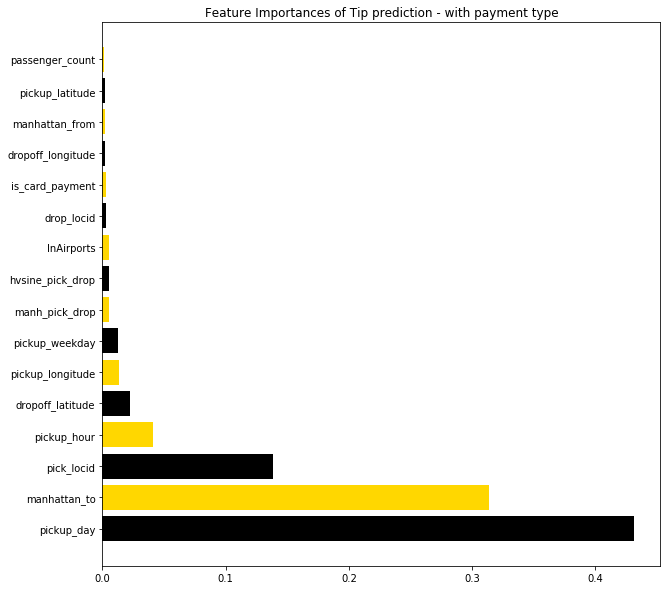

In [48]:
predictors = train.columns.values
importances=forest.feature_importances_
std = np.std([forest.feature_importances_ for tree in forest.estimators_],axis=0)
print(std)
indices = np.argsort(importances)[::-1]
sorted_important_features=[]
for i in indices:
    sorted_important_features.append(predictors[i])
plt.figure(figsize=(10,10))
plt.title("Feature Importances of Tip prediction - with payment type")
plt.barh(range(len(indices)), importances[indices],
       color=["black","gold"], yerr=std[indices], align="center")
plt.yticks(range(len(indices)), sorted_important_features, rotation='horizontal');